Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 155MB/s]
100%|██████████| 2/2 [00:05<00:00,  2.88s/it]


Epoch 1: Train Loss = 0.8504, Test Loss = 0.7922, Accuracy = 0.5471


100%|██████████| 2/2 [00:04<00:00,  2.44s/it]


Epoch 2: Train Loss = 0.1927, Test Loss = 0.7291, Accuracy = 0.5561


100%|██████████| 2/2 [00:04<00:00,  2.41s/it]


Epoch 3: Train Loss = 0.0677, Test Loss = 0.6949, Accuracy = 0.6188


100%|██████████| 2/2 [00:04<00:00,  2.38s/it]


Epoch 4: Train Loss = 0.0452, Test Loss = 0.6261, Accuracy = 0.6816


100%|██████████| 2/2 [00:04<00:00,  2.40s/it]


Epoch 5: Train Loss = 0.1645, Test Loss = 0.6679, Accuracy = 0.6771


100%|██████████| 2/2 [00:04<00:00,  2.39s/it]


Epoch 6: Train Loss = 0.0263, Test Loss = 0.6465, Accuracy = 0.6816


100%|██████████| 2/2 [00:04<00:00,  2.39s/it]


Epoch 7: Train Loss = 0.0282, Test Loss = 0.5086, Accuracy = 0.7668


100%|██████████| 2/2 [00:05<00:00,  2.59s/it]


Epoch 8: Train Loss = 0.0139, Test Loss = 0.4354, Accuracy = 0.8206


100%|██████████| 2/2 [00:04<00:00,  2.41s/it]


Epoch 9: Train Loss = 0.0296, Test Loss = 0.3966, Accuracy = 0.8296


100%|██████████| 2/2 [00:05<00:00,  2.72s/it]


Epoch 10: Train Loss = 0.0138, Test Loss = 0.3548, Accuracy = 0.8744


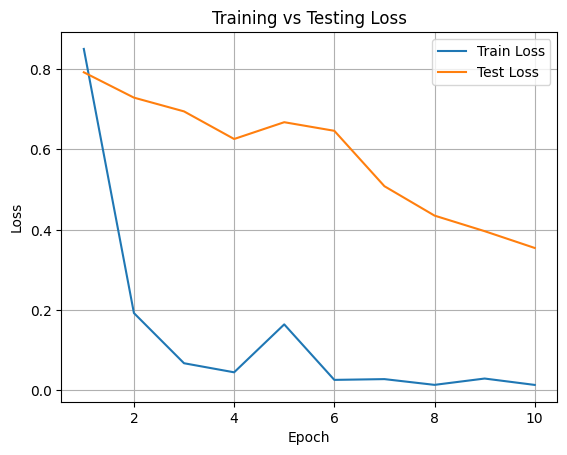

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import os, glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# Dataset Class
class MenWomenDataset(Dataset):
    def __init__(self, root_dir, image_size=224):
        self.root_dir = root_dir
        self.image_size = image_size
        self.class_names = ['men', 'women']

        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

        self.data = []
        self.labels = []

        for label, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.root_dir, class_name)
            image_paths = glob.glob(os.path.join(class_dir, '*.jpg')) + glob.glob(os.path.join(class_dir, '*.png'))
            self.data.extend(image_paths)
            self.labels.extend([label] * len(image_paths))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        return image, label

# Load dataset
train_dataset = MenWomenDataset('/kaggle/input/men-woman/dataset/train')
test_dataset = MenWomenDataset('/kaggle/input/men-woman/dataset/test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained model
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train model
num_epochs = 10
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    avg_train_loss = train_loss / len(train_dataset)
    train_losses.append(avg_train_loss)

    # Evaluation
    model.eval()
    correct, total, test_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_test_loss = test_loss / len(test_dataset)
    test_losses.append(avg_test_loss)
    acc = correct / total

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}, Accuracy = {acc:.4f}")

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'men_women_checkpoint.pth')

# Plot
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.grid()
plt.legend()
plt.show()


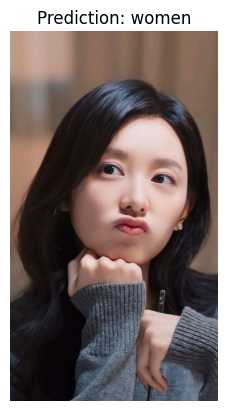

Prediction: women


In [2]:
def load_model(weight_path, device):
    model = resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 2)
    checkpoint = torch.load(weight_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

def predict(image_path, model, device):
    class_names = ['men', 'women']
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, pred = torch.max(output, 1)

    label = class_names[pred.item()]
    plt.imshow(image)
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()
    print(f"Prediction: {label}")

# Load model & predict
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_model('men_women_checkpoint.pth', device)
predict('/kaggle/input/men-woman/dataset/WADON.jpeg', model, device)
